In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import random

from sales_forecasting.utils import timeseries_split
from sales_forecasting.plot import plot_timeseries, plot_feature_importance
from sales_forecasting.features import col_name

In [4]:
random.seed(42)
np.random.seed(42)

In [5]:
df = pd.read_parquet(".data/df_agg_monthly_oversampled.parquet")

In [25]:
train_split, valid_split = timeseries_split(df, max_month=33, col='date_block_num', continuous=False)
train_test_split, test_split = timeseries_split(df, max_month=34, col='date_block_num', continuous=False)

In [7]:
target_col = 'item_cnt_month'
train_target, valid_target = train_split[target_col].clip(0, 20), valid_split[target_col].clip(0, 20)

In [8]:
cols_to_drop = [target_col, 'date_block_num', 'shop_id', 'item_id']
X_train, X_valid = train_split.drop(columns=cols_to_drop), valid_split.drop(columns=cols_to_drop)

# Naive model

In [ ]:
class NaiveMeanModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def fit(self):
        self.mean = self.y.mean()

    def transform(self, X):
        return np.repeat(self.mean, X.shape[0])

    def predict(self, X):
        return self.transform(X)
    
model = NaiveMeanModel(X_train, train_target)
model.fit()
y_pred = model.predict(X_valid).clip(0, 20)
metrics.root_mean_squared_error(valid_target.values, y_pred)

In [ ]:
from sklearn.compose import ColumnTransformer

ohe_cols = ['city_id', 'item_category_id', 'general_item_category_id', 'date_month']
num_cols = [*col_name("lagged", list(range(1, 12))), *col_name('rolling', [3, 6, 9]), 'months_since_last_buy']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), num_cols),
        ('cat', preprocessing.OneHotEncoder(handle_unknown='ignore'), ohe_cols)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

# Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train_preprocessed, train_target.values)
y_pred = model.predict(X_valid_preprocessed).clip(0, 20)
metrics.root_mean_squared_error(valid_target.values, y_pred)

# Decision Tree

In [ ]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train_preprocessed, train_target.values)
y_pred = model.predict(X_valid_preprocessed).clip(0, 20)
metrics.root_mean_squared_error(valid_target.values, y_pred)

# Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators=5)
model.fit(X_train_preprocessed, train_target.values)
y_pred = model.predict(X_valid_preprocessed).clip(0, 20)
metrics.root_mean_squared_error(valid_target.values, y_pred)

# Gradient Boosted Trees

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.361728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 21137776, number of used features: 29
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Start training from score 0.084545
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
LGBM model Valid RMSE:  0.379214483651043


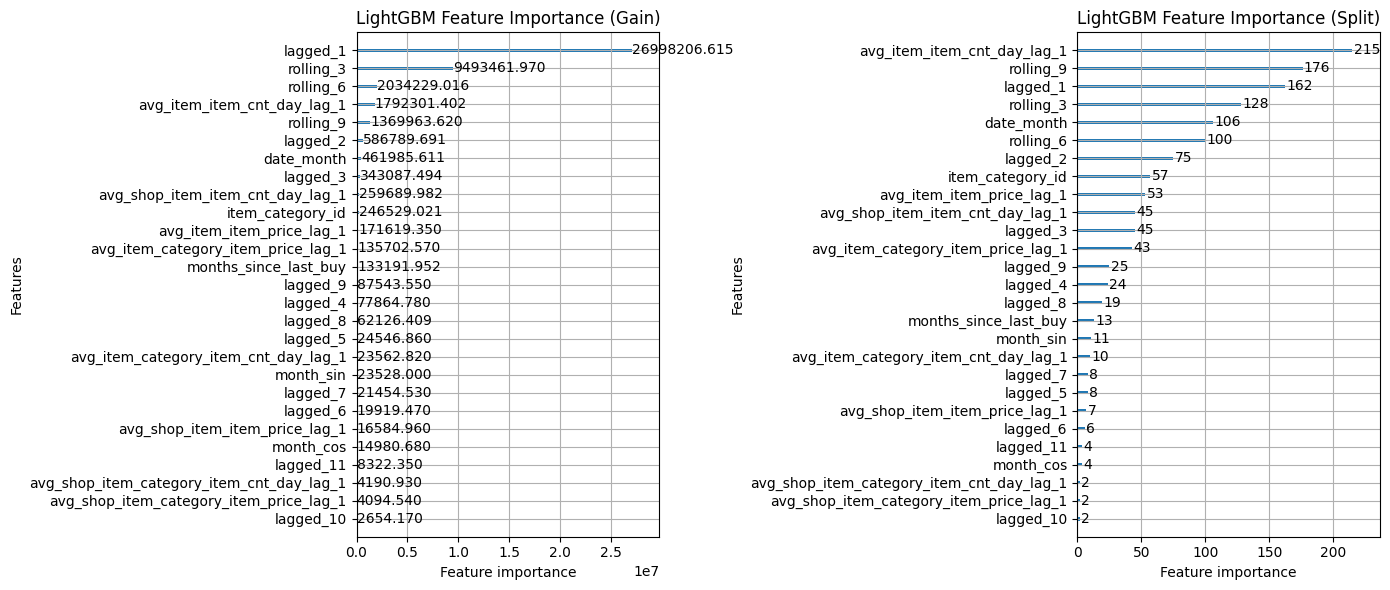

In [10]:
params = {
    'random_state': 42,
    'num_leaves': 28,
    'max_depth': 43,
    'learning_rate': 0.07188714405942678,
    'n_estimators': 50,
    'reg_alpha': 1.862771282197631,
    'reg_lambda': 0.6080693179624701,
    'colsample_bytree': 1.0,
    'subsample': 0.7,
    'min_child_samples': 236,
    'min_data_per_groups': 89
}

model = lgb.LGBMRegressor(**params, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
model.fit(X_train, train_target, eval_set=[(X_valid, valid_target)])

y_pred = model.predict(X_valid)
rmse = metrics.root_mean_squared_error(valid_target.values, y_pred)
print("LGBM model Valid RMSE: ", rmse)
plot_feature_importance(model)

In [14]:
X_valid

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,lagged_3,lagged_4,...,rolling_9,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy
13,0,40,11,9,0.707031,-0.707031,0,0,0,0,...,0.0,169.0,1.0,4488.0,1.000000,297.00,1.083984,279.500,1.045898,13
32,0,76,15,9,0.707031,-0.707031,0,0,0,0,...,0.0,169.0,1.0,4488.0,1.000000,297.00,1.083984,1939.000,1.550781,18
47,0,40,11,9,0.707031,-0.707031,0,0,0,0,...,0.0,169.0,1.0,58.0,1.000000,297.00,1.083984,279.500,1.045898,14
63,0,40,11,9,0.707031,-0.707031,0,0,0,0,...,0.0,169.0,1.0,100.0,1.000000,297.00,1.083984,279.500,1.045898,15
77,0,40,11,9,0.707031,-0.707031,0,0,0,0,...,0.0,169.0,1.0,58.0,1.000000,297.00,1.083984,279.500,1.045898,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460846,30,31,8,9,0.707031,-0.707031,0,0,0,0,...,0.0,699.0,1.0,59.0,1.000000,353.25,1.000000,664.500,1.254883,26
29460871,30,54,12,9,0.707031,-0.707031,0,0,0,0,...,0.0,699.0,1.0,150.0,1.250000,353.25,1.000000,228.625,1.278320,24
29460898,30,49,12,9,0.707031,-0.707031,0,0,0,0,...,0.0,299.0,1.0,299.0,1.049805,334.50,1.000000,469.500,1.098633,15
29460933,30,62,14,9,0.707031,-0.707031,0,0,0,0,...,0.0,299.0,1.0,798.5,1.000000,899.00,1.000000,1558.000,1.097656,33


In [37]:
train_test_split[train_test_split.set_index(['shop_id', 'item_id']).index.isin(lst_plot_report)]

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date_block_num,shop_id,item_id,item_cnt_month,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,...,rolling_9,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy
4022544,27,7,5551,6,5,55,13,3,0.707031,0.707031,...,0.666504,699.0,1.000000,295.0,1.000000,304.50,1.006836,305.25,1.028320,0
4022545,28,7,5551,1,5,55,13,4,0.866211,0.500000,...,0.666504,399.0,1.200195,396.0,1.215820,292.75,1.018555,308.00,1.032227,0
4022546,29,7,5551,0,5,55,13,5,0.965820,0.258789,...,0.666504,399.0,1.200195,397.5,1.045898,317.50,1.007812,316.00,1.017578,0
4022547,30,7,5551,1,5,55,13,6,1.000000,0.000000,...,0.666504,399.0,1.000000,389.5,1.029297,318.50,1.017578,317.75,1.016602,1
4022548,31,7,5551,2,5,55,13,7,0.965820,-0.258789,...,0.666504,399.0,1.000000,399.0,1.068359,306.25,1.006836,311.00,1.012695,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22393136,29,44,14127,0,21,38,11,5,0.965820,0.258789,...,0.777832,999.0,1.000000,809.5,1.000000,868.00,1.000000,664.00,1.041992,6
22393137,30,44,14127,0,21,38,11,6,1.000000,0.000000,...,0.444336,999.0,1.000000,619.0,1.000000,263.25,1.000000,572.50,1.005859,7
22393138,31,44,14127,0,21,38,11,7,0.965820,-0.258789,...,0.111084,999.0,1.000000,672.5,1.000000,749.00,1.000000,565.50,1.026367,8
22393139,32,44,14127,0,21,38,11,8,0.866211,-0.500000,...,0.000000,999.0,1.000000,699.0,1.000000,382.25,1.000000,474.25,1.022461,9


In [38]:
lst_plot_report = [(29, 5036), (16, 4678), (44, 14127), (24, 20253), (7, 5551), (39, 18454)]
df_plot_report = train_test_split[train_test_split.set_index(['shop_id', 'item_id']).index.isin(lst_plot_report)]
df_plot_report = df_plot_report.assign(pred=model.predict(df_plot_report.drop(columns=cols_to_drop)))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[LightGBM] [Warning] Unknown parameter: min_data_per_groups


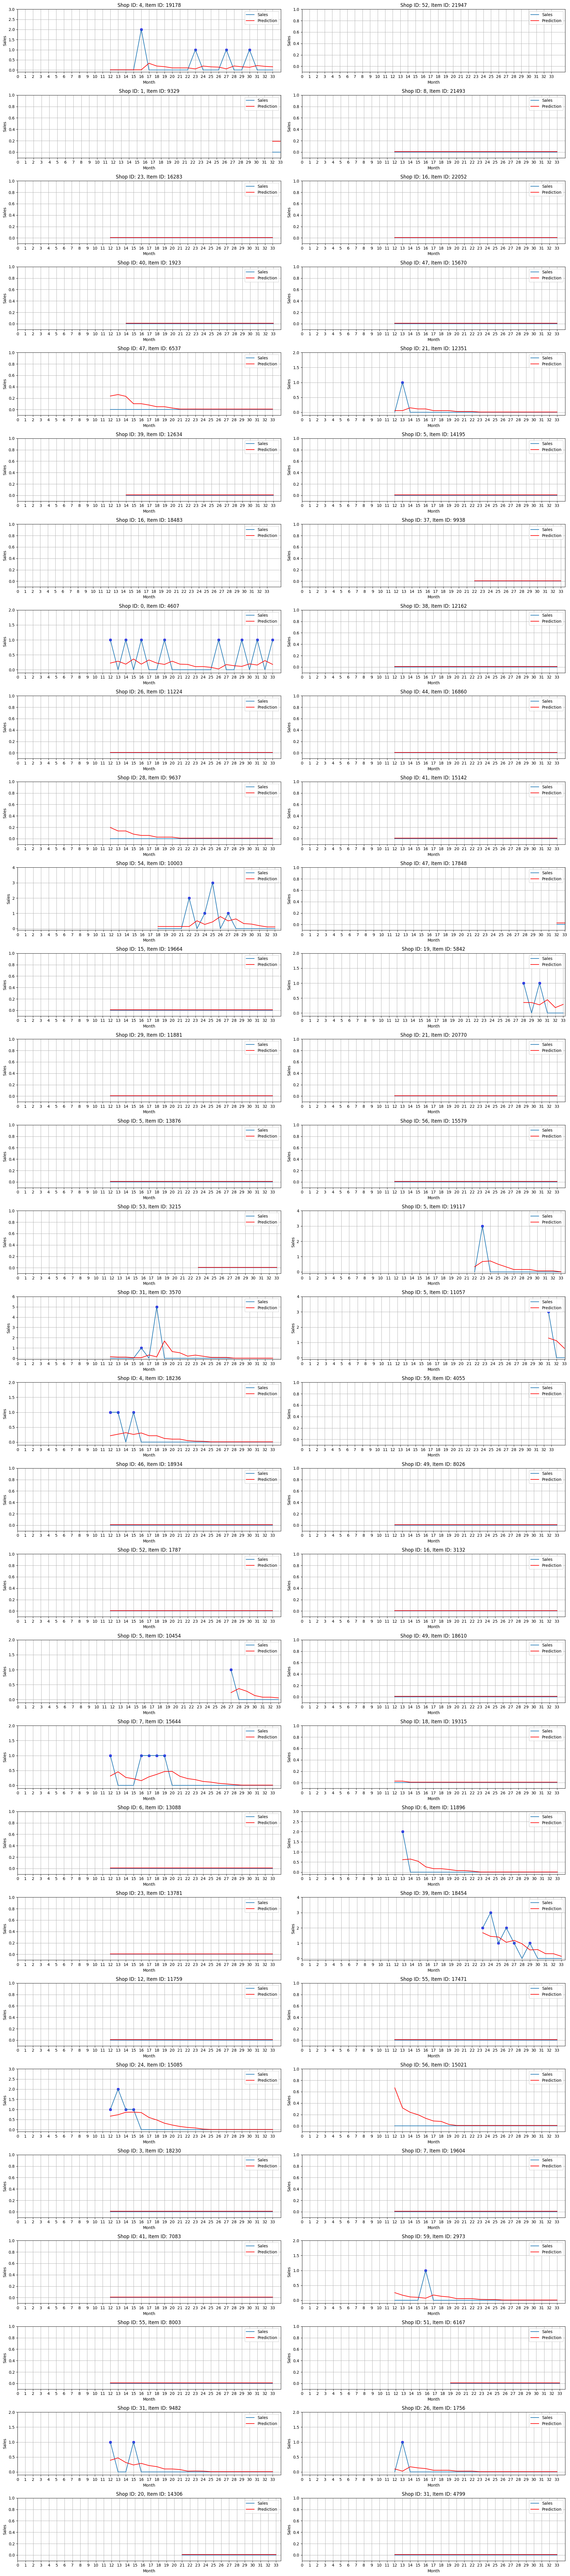

In [35]:
plot_timeseries(train_test_split.assign(pred=model.predict(train_test_split.drop(cols_to_drop, axis=1))), plt_rows=30, plt_cols=2, rand=True, pred_col='pred')

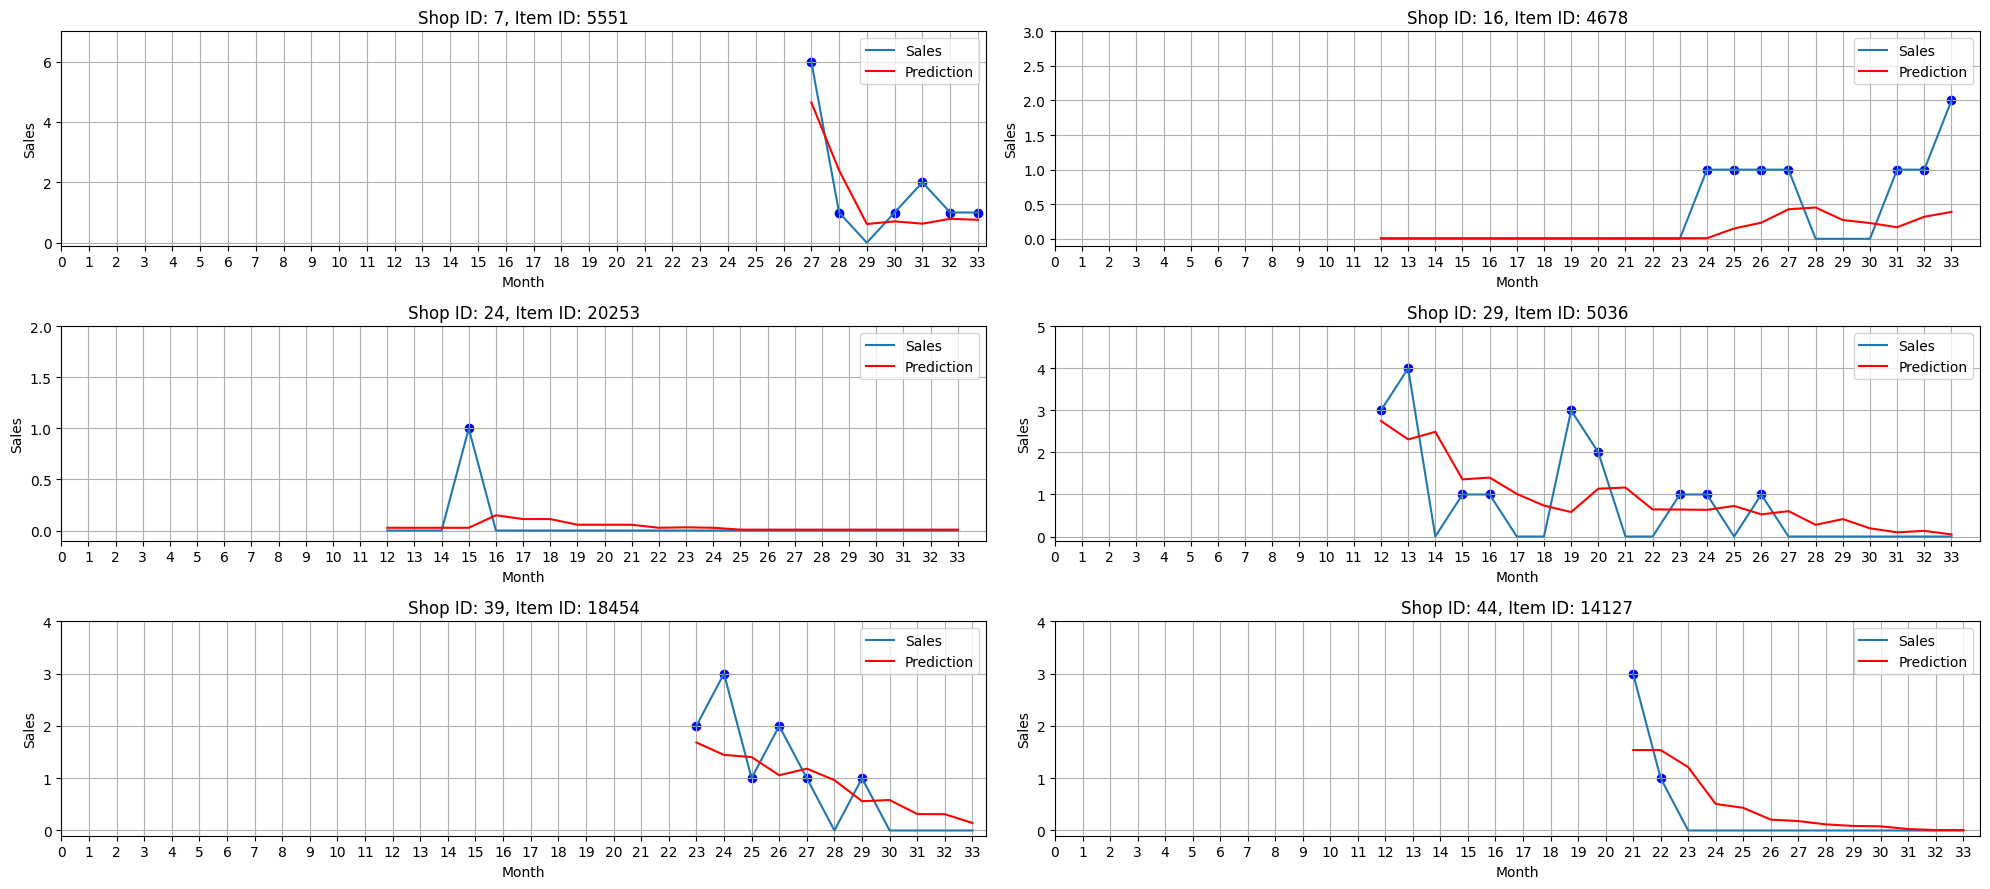

In [45]:
plot_timeseries(df_plot_report, plt_rows=3, plt_cols=2, rand=False, pred_col='pred', save_path='assets/plots/lgbm_preds.png')
